In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from tqdm import tqdm
from cartopy import crs as ccrs

from nzdownscale.dataprocess.config_local import DATA_PATHS
from nzdownscale.dataprocess.config import VAR_ERA5, VAR_STATIONS
from nzdownscale.dataprocess import era5, stations, wrf

/home/emily/mambaforge/envs/deepsensor2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
var = 'surface_pressure'
year = 2020

# Load ERA5

In [5]:
process_era5 = era5.ProcessERA5()
era5_var = VAR_ERA5[var]['var_name']
era5_ds = process_era5.load_ds(var, year)
era5_ds = era5_ds.compute() / 100 # Pa to hPa

# Load stations

In [4]:
process_stations = stations.ProcessStations()
station_var = VAR_STATIONS[var]['var_name']
station_df = process_stations.load_stations(var, year)

Loading stations:   0%|          | 0/368 [00:00<?, ?it/s]

Filtering stations: 100%|██████████| 213/213 [00:41<00:00,  5.12it/s]


Concatenating stations into pd.DataFrame


In [5]:
len_df = len(station_df)
station_df = station_df.dropna(subset=[station_var])
print(f'Dropped {len_df - len(station_df)} NaN values')
station_df

Dropped 86072 NaN values


stn_lev_pres
time       station_name       latitude  longitude              
2020-01-01 AKAROA EWS         -43.80938 172.96574        1002.0
           AKITIO EWS         -40.57728 176.44889         981.0
           ALEXANDRA AWS      -45.21452 169.37549         983.8
           ALEXANDRA CWS      -45.25366 169.39205         993.2
           ALEXANDRA EWS      -45.25458 169.38448         993.7
...                                                         ...
2020-12-31 WHANGAREI EWS      -35.74440 174.32868        1019.2
           WHITIANGA AERO AWS -36.83237 175.67542        1020.5
           WHITIANGA EWS      -36.82817 175.67231        1020.3
           WINCHMORE 2 EWS    -43.78935 171.79032        1001.8
           WINDSOR EWS        -45.00829 170.82281        1012.4

[1554449 rows x 1 columns]

# Plots

In [23]:
era5_mean = float(era5_ds[era5_var].mean(dim=['time', 'latitude', 'longitude']).values)
station_mean = np.mean(station_df[station_var].values)
print(f'ERA5 overall mean: {era5_mean}, \nStation overall mean: {station_mean}')

ERA5 overall mean: 960.1135864257812, 
Station overall mean: 997.7843082661446


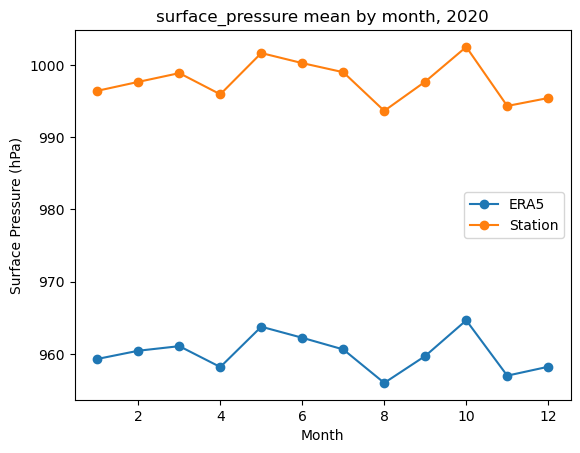

In [24]:
era5_mean_by_month = era5_ds[era5_var].groupby('time.month').mean(dim=['time', 'latitude', 'longitude']).values

station_df_reset = station_df.reset_index()
station_df_reset['time'] = pd.to_datetime(station_df_reset['time'])
station_df_reset = station_df_reset.set_index('time')
station_mean_by_month = station_df_reset[station_var].resample('ME').mean().values

fig, ax = plt.subplots()
ax.plot(np.arange(1, 13), era5_mean_by_month, label='ERA5', marker='o')
ax.plot(np.arange(1, 13), station_mean_by_month, label='Station', marker='o')
ax.set_xlabel('Month')
ax.set_ylabel('Surface Pressure (hPa)')
ax.legend()
ax.set_title(f'{var} mean by month, {year}')
plt.show();

# By station

In [25]:
stations = station_df_reset['station_name'].unique()

In [26]:
stats_by_station = {}
for station in tqdm(stations):
    station_data = station_df_reset[station_df_reset['station_name'] == station]
    station_data_vals = station_data[station_var]
    station_mean = station_data_vals.mean()
    station_std = station_data_vals.std()

    era5_data = era5_ds[era5_var].sel(latitude=station_data['latitude'].unique()[0],
                                       longitude=station_data['longitude'].unique()[0],
                                       method='nearest')
    era5_data_vals = era5_data.values
    era5_mean = era5_data_vals.mean()
    era5_std = era5_data_vals.std()

    stats_by_station[station] = {'station_mean': station_mean, 
                                 'station_std': station_std,
                                 'era5_mean': era5_mean,
                                 'era5_std': era5_std}

  0%|          | 0/185 [00:00<?, ?it/s]

100%|██████████| 185/185 [00:14<00:00, 12.92it/s]


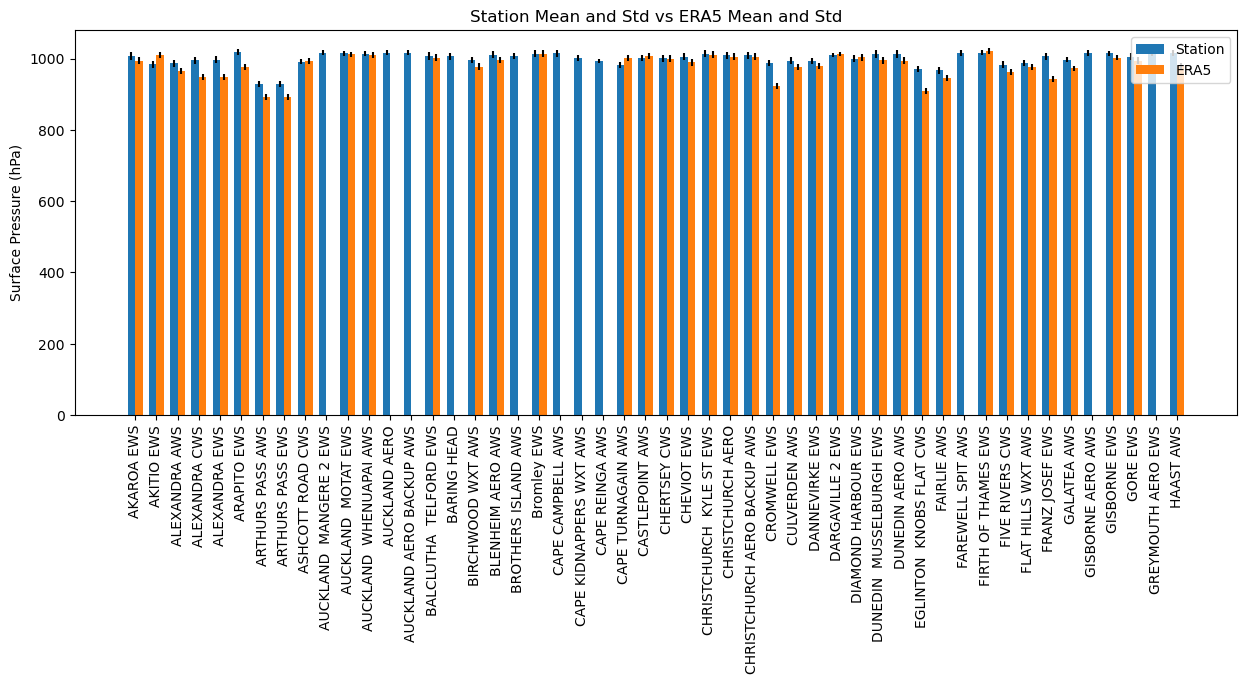

In [27]:
num_stations = len(stats_by_station)

station_names = list(stats_by_station.keys())

station_means = [stats_by_station[station]['station_mean'] for station in station_names]
station_stds = [stats_by_station[station]['station_std'] for station in station_names]

era5_means = [stats_by_station[station]['era5_mean'] for station in station_names]
era5_stds = [stats_by_station[station]['era5_std'] for station in station_names]

bar_width = 0.35
bar_positions = np.arange(num_stations)

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the station means and stds
ax.bar((bar_positions - bar_width/2)[:50], station_means[:50], bar_width, yerr=station_stds[:50], label='Station')
# Plot the era5 means and stds
ax.bar((bar_positions + bar_width/2)[:50], era5_means[:50], bar_width, yerr=era5_stds[:50], label='ERA5')

ax.set_xticks(bar_positions[:50])
ax.set_xticklabels(station_names[:50], rotation=90)

ax.set_ylabel('Surface Pressure (hPa)')
ax.set_title('Station Mean and Std vs ERA5 Mean and Std')
ax.legend()
plt.show();

# Visualise

In [28]:
cmap = 'plasma'

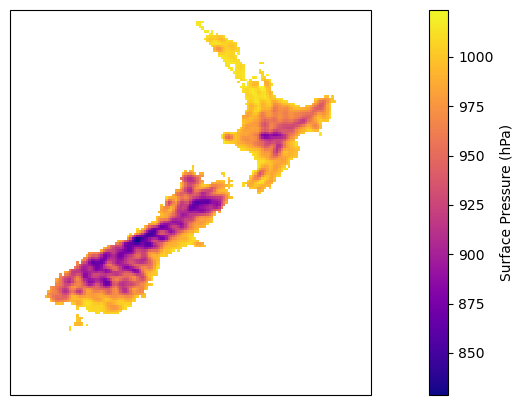

In [29]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})
mean_era5 = era5_ds[era5_var].mean(dim='time')
max_era5 = mean_era5.max().values
min_era5 = mean_era5.min().values
mean_era5.plot(ax=ax, 
                cmap=cmap, 
                cbar_kwargs={'label': 'Surface Pressure (hPa)'},
                vmin=min_era5, vmax=max_era5)
ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())

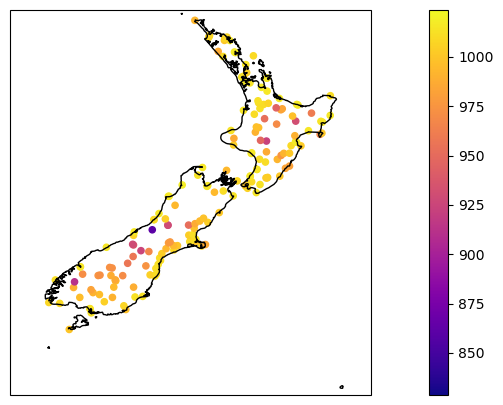

In [30]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})
station_means = station_df.groupby(['latitude', 'longitude']).mean().reset_index()
station_means.plot.scatter(x='longitude', 
                           y='latitude',
                           c=station_means[station_var], 
                           cmap=cmap,
                           ax=ax,
                           vmin=min_era5, vmax=max_era5)
ax.coastlines()
ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())

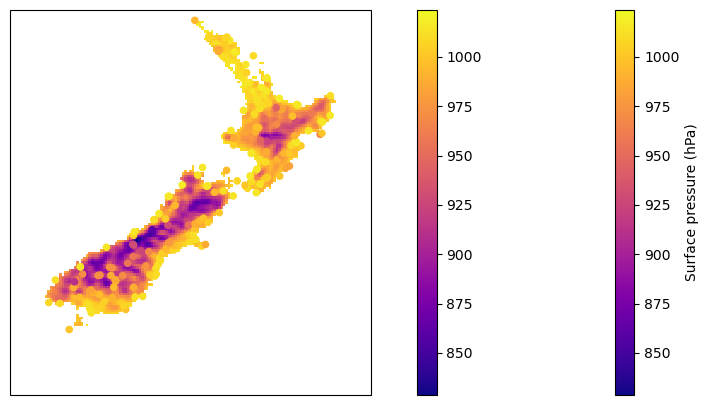

In [31]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})

mean_era5.plot(ax=ax, 
                cmap=cmap, 
                cbar_kwargs={'label': 'Surface pressure (hPa)'},
                vmin=min_era5, vmax=max_era5)
station_means.plot.scatter(x='longitude', 
                           y='latitude',
                           c=station_means[station_var], 
                           cmap=cmap,
                           ax=ax,
                           vmin=min_era5, vmax=max_era5)

ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())


In [8]:
station_df

stn_lev_pres
time       station_name       latitude  longitude              
2020-01-01 AKAROA EWS         -43.80938 172.96574        1002.0
           AKITIO EWS         -40.57728 176.44889         981.0
           ALEXANDRA AWS      -45.21452 169.37549         983.8
           ALEXANDRA CWS      -45.25366 169.39205         993.2
           ALEXANDRA EWS      -45.25458 169.38448         993.7
...                                                         ...
2020-12-31 WHANGAREI EWS      -35.74440 174.32868        1019.2
           WHITIANGA AERO AWS -36.83237 175.67542        1020.5
           WHITIANGA EWS      -36.82817 175.67231        1020.3
           WINCHMORE 2 EWS    -43.78935 171.79032        1001.8
           WINDSOR EWS        -45.00829 170.82281        1012.4

[1554449 rows x 1 columns]

Text(0.5, 1.0, 'Station Pressure Histogram')

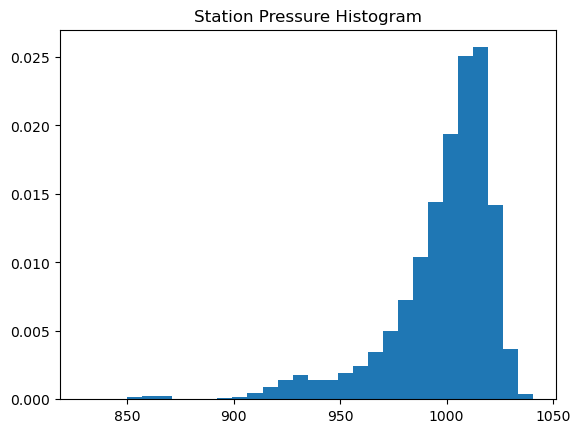

In [6]:
fig, ax = plt.subplots()
ax.hist(station_df['stn_lev_pres'].values, bins=30, density=True)
ax.set_title('Station Pressure Histogram')

In [7]:
from scipy.optimize import minimize
def custom_optimizer(func, x0, args=(), disp=0):
    res = minimize(func, x0, args, method="slsqp", options={"disp": disp})
    if res.success:
        return res.x
    raise RuntimeError('optimization routine failed')

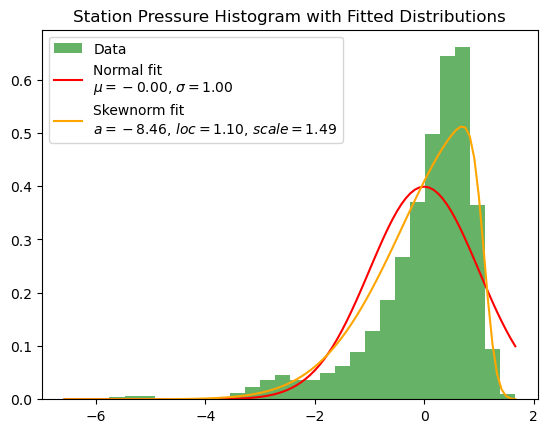

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, lognorm, beta, skewnorm

# Get the pressure data (replace with your actual column name)
data = station_df['stn_lev_pres'].values
data = (data - np.mean(data)) / np.std(data)  # Standardize
# data = (data - min(data)) / (max(data) - min(data))  # Normalize to [0, 1]
# data = np.clip(data, 0.001, 0.999)  # Clip to avoid log(0) and log(1)

# Plot the histogram of the data
fig, ax = plt.subplots()
ax.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data')

# Fit and plot the Normal distribution
mu, std = norm.fit(data)
x = np.linspace(min(data), max(data), 100)
p_norm = norm.pdf(x, mu, std)
ax.plot(x, p_norm, 'r-', label=f'Normal fit\n$\\mu={mu:.2f}$, $\\sigma={std:.2f}$')

# # Fit and plot the Gamma distribution
# shape, loc, scale = gamma.fit(data, floc=0)
# p_gamma = gamma.pdf(x, shape, loc, scale)
# ax.plot(x, p_gamma, 'b-', label=f'Gamma fit\n$\\alpha={shape:.2f}$, $\\beta={scale:.2f}$')

# # Fit and plot the Log-Normal distribution
# shape_lognorm, loc_lognorm, scale_lognorm = lognorm.fit(data, floc=0)
# p_lognorm = lognorm.pdf(x, shape_lognorm, loc_lognorm, scale_lognorm)
# ax.plot(x, p_lognorm, 'm-', label=f'Log-Normal fit\n$\\mu={shape_lognorm:.2f}$, $\\sigma={scale_lognorm:.2f}$')


#Skewnorm
a, loc, scale = skewnorm.fit(data)
p_skewnorm = skewnorm.pdf(x, a, loc, scale)
ax.plot(x, p_skewnorm, c='orange', label=f'Skewnorm fit\n$a={a:.2f}$, $loc={loc:.2f}$, $scale={scale:.2f}$')

# # Fit and plot the Beta distribution (normalize data to [0, 1] range)
# data_norm = (data - min(data)) / (max(data) - min(data))  # Normalize to [0, 1]
# alpha, beta_, loc_beta, scale_beta = beta.fit(data, floc=0, fscale=1)
# p_beta = beta.pdf(x, alpha, beta_, loc_beta, scale_beta)
# ax.plot(x, p_beta, 'm-', label=f'Beta fit\n$\\alpha={alpha:.2f}$, $\\beta={beta_:.2f}$')

# Customize plot
ax.set_title('Station Pressure Histogram with Fitted Distributions')
ax.legend()

plt.show()


/tmp/ipykernel_1965771/2306431466.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y-" (-> color='y'). The keyword argument will take precedence.
  ax.plot(x_norm, p_beta, 'y-', label=f'Beta fit\n$\\alpha={alpha:.2f}$, $\\beta={beta_:.2f}$',


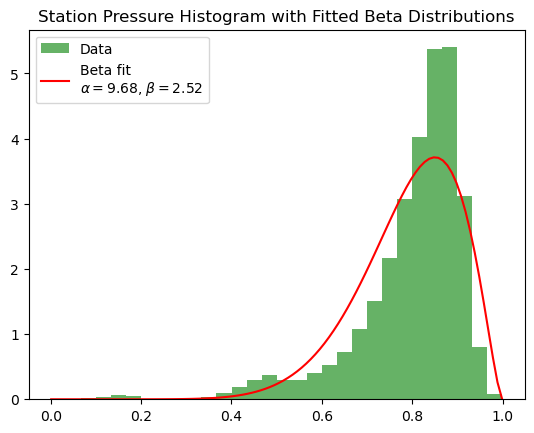

In [9]:
fig, ax = plt.subplots()



# Fit and plot the Beta distribution (normalize data to [0, 1] range)
data_norm = (data - min(data)) / (max(data) - min(data))  # Normalize to [0, 1]
data_norm = np.clip(data_norm, 0.001, 0.999)
x_norm = np.linspace(min(data_norm), max(data_norm), 100)

ax.hist(data_norm, bins=30, density=True, alpha=0.6, color='g', label='Data')

alpha, beta_, loc_beta, scale_beta = beta.fit(data_norm, floc=0, fscale=1)
p_beta = beta.pdf(x_norm, alpha, beta_, loc_beta, scale_beta)
ax.plot(x_norm, p_beta, 'y-', label=f'Beta fit\n$\\alpha={alpha:.2f}$, $\\beta={beta_:.2f}$',
        c='r')

ax.set_title('Station Pressure Histogram with Fitted Beta Distributions')
ax.legend()


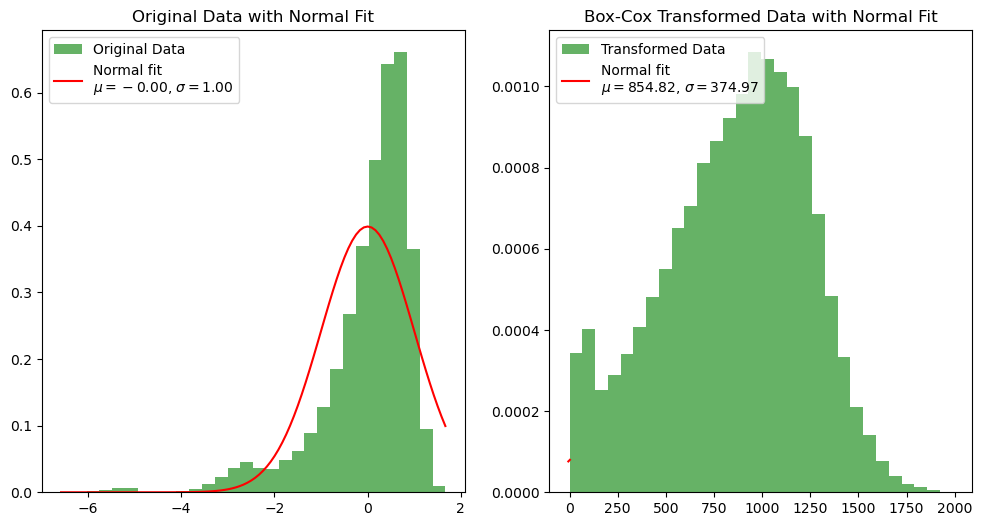

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, skewnorm, boxcox, yeojohnson

# Get the pressure data (replace with your actual column name)
data = station_df['stn_lev_pres'].values
data = (data - np.mean(data)) / np.std(data)  # Standardize
# data = (data - min(data)) / (max(data) - min(data))  # Normalize to [0, 1]
# data = np.clip(data, 0.001, 0.999)  # Clip to avoid log(0) and log(1)

# Apply Box-Cox transformation to the data (ensure data is positive)
# Box-Cox transformation requires strictly positive data, hence we shift if necessary
data_positive = data - min(data) + 1e-5  # Ensure positive data
data_transformed, lambda_ = boxcox(data_positive)

# Plot the histogram of the original and transformed data
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original data
ax[0].hist(data, bins=30, density=True, alpha=0.6, color='g', label='Original Data')

# Fit and plot the Normal distribution on the original data
mu, std = norm.fit(data)
x = np.linspace(min(data), max(data), 100)
p_norm = norm.pdf(x, mu, std)
ax[0].plot(x, p_norm, 'r-', label=f'Normal fit\n$\\mu={mu:.2f}$, $\\sigma={std:.2f}$')

# Transformed data
ax[1].hist(data_transformed, bins=30, density=True, alpha=0.6, color='g', label='Transformed Data')

# Fit and plot the Normal distribution on the transformed data
mu_transformed, std_transformed = norm.fit(data_transformed)
p_norm_transformed = norm.pdf(x, mu_transformed, std_transformed)
ax[1].plot(x, p_norm_transformed, 'r-', label=f'Normal fit\n$\\mu={mu_transformed:.2f}$, $\\sigma={std_transformed:.2f}$')

# Customize plot
ax[0].set_title('Original Data with Normal Fit')
ax[1].set_title('Box-Cox Transformed Data with Normal Fit')
ax[0].legend()
ax[1].legend()

plt.show()


In [14]:
from scipy.stats import probplot

((array([-4.9141195 , -4.73740211, -4.64194886, ...,  4.64194886,
          4.73740211,  4.9141195 ]),
  array([-6.5749869 , -6.51658905, -6.50880267, ...,  1.65132344,
          1.66300301,  1.6668962 ])),
 (0.9124990958416693, -7.334295562135622e-15, 0.9124959527602426))

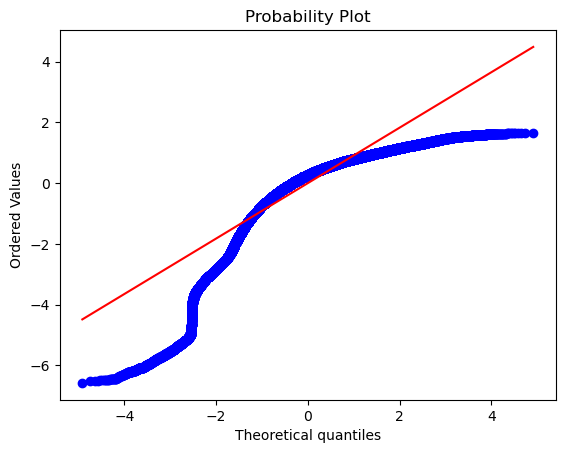

In [15]:
probplot(data, dist='norm', plot=plt)

((array([-4.9141195 , -4.73740211, -4.64194886, ...,  4.64194886,
          4.73740211,  4.9141195 ]),
  array([1.00001988e-05, 6.55931509e-02, 7.54944523e-02, ...,
         1.27228219e+04, 1.28031581e+04, 1.28300267e+04])),
 (2371.7582856064887, 5432.480498325751, 0.9921064018227223))

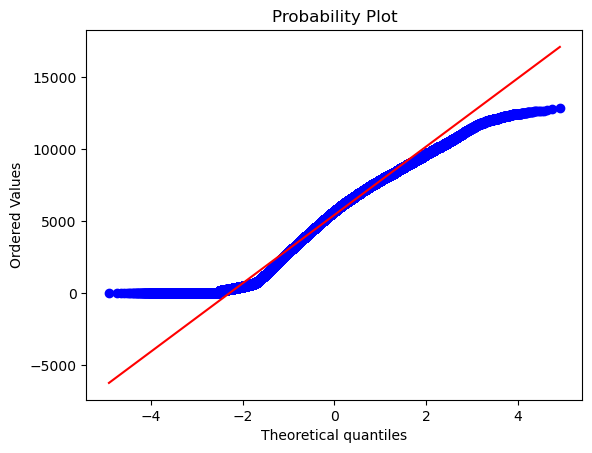

In [18]:
probplot(data_transformed, dist='norm', plot=plt)

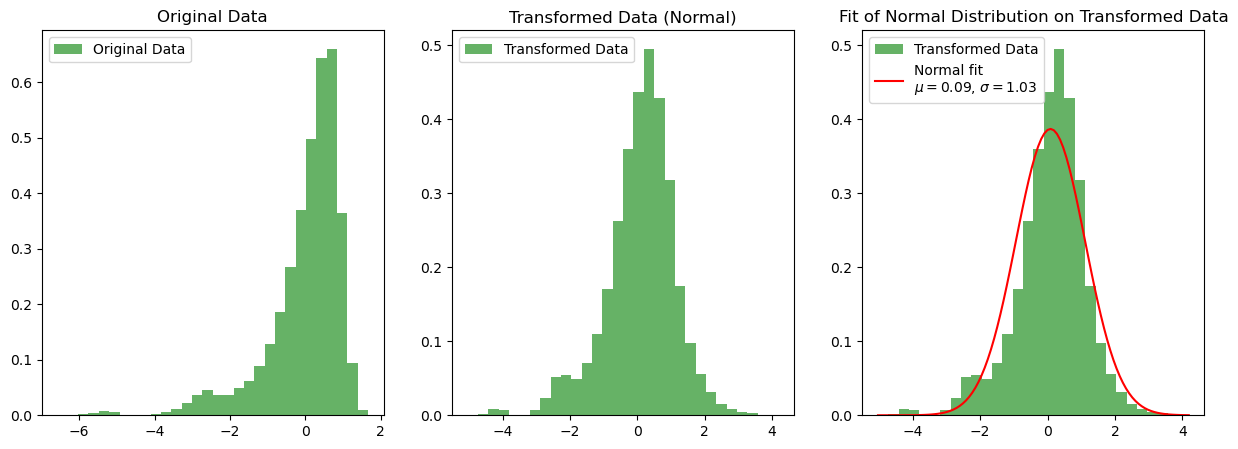

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, norm

# Fit a skew normal distribution to your data
a, loc, scale = skewnorm.fit(data)

# Transform data using the CDF of the skew normal to a uniform distribution
uniform_data = skewnorm.cdf(data, a, loc, scale)

# Apply the inverse CDF of the normal distribution to get normal data
normal_data = norm.ppf(uniform_data)

# Plot the original, transformed, and the normal fit
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Original data
ax[0].hist(data, bins=30, density=True, alpha=0.6, color='g', label='Original Data')
ax[0].set_title('Original Data')

# Transformed data
ax[1].hist(normal_data, bins=30, density=True, alpha=0.6, color='g', label='Transformed Data')
ax[1].set_title('Transformed Data (Normal)')

# Normal fit on the transformed data
mu, std = norm.fit(normal_data)
x = np.linspace(min(normal_data), max(normal_data), 100)
p_norm = norm.pdf(x, mu, std)
ax[2].hist(normal_data, bins=30, density=True, alpha=0.6, color='g', label='Transformed Data')
ax[2].plot(x, p_norm, 'r-', label=f'Normal fit\n$\\mu={mu:.2f}$, $\\sigma={std:.2f}$')
ax[2].set_title('Fit of Normal Distribution on Transformed Data')

# Show the plot
for a in ax:
    a.legend()

plt.show()
